In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
from __future__ import print_function
import numpy as np
import pandas as pd
import datetime, time, json
from keras.models import Model
from keras.layers import Input, TimeDistributed, Dense, Lambda, concatenate, Dropout, BatchNormalization
from keras.layers import merge
from keras.layers import Convolution1D, GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from keras.regularizers import l2
from keras.callbacks import Callback, ModelCheckpoint
from keras import backend as K
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [0]:
PATH = 'gdrive/My Drive/quora-question-pairs/'

Q1_TRAIN = 'q1_train.npy'
Q2_TRAIN = 'q2_train.npy'
LABEL_TRAIN = 'label_train.npy'
WORD_EMBEDDING_MATRIX = 'word_embedding_matrix.npy'
NB_WORDS = 'word_index.json'
MODEL_WEIGHTS = 'question_pairs_weights.h5'
MAX_SEQ_LENGTH = 50
EMBEDDING_DIM = 300

EPOCHS = 25
BATCH_SIZE = 32

In [0]:
# Loading dataset
q1_data = np.load(open(PATH + Q1_TRAIN, 'rb'))
q2_data = np.load(open(PATH + Q2_TRAIN, 'rb'))
labels = np.load(open(PATH + LABEL_TRAIN, 'rb'))
word_embedding_matrix = np.load(open(PATH + WORD_EMBEDDING_MATRIX, 'rb'))
with open(PATH + NB_WORDS, 'r') as f:
    nb_words = json.load(f)['nb_words']

In [0]:
# Split dataset to get validation and test sets.
X = np.stack((q1_data, q2_data), axis=1)
y = labels

X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test =  train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify=y_test)

Q1_train = X_train[:,0]
Q2_train = X_train[:,1]
Q1_val = X_val[:,0]
Q2_val = X_val[:,1]
Q1_test = X_test[:,0]
Q2_test = X_test[:,1]

In [0]:
from keras.layers.recurrent import LSTM, GRU
from keras.models import Sequential
DROPOUT = 0.2

question1 = Input(shape=(MAX_SEQ_LENGTH,))
question2 = Input(shape=(MAX_SEQ_LENGTH,))

q1 = Embedding(nb_words + 1, 
                 EMBEDDING_DIM, 
                 weights=[word_embedding_matrix], 
                 input_length=MAX_SEQ_LENGTH, 
                 trainable=False)(question1)

q2 = Embedding(nb_words + 1, 
                 EMBEDDING_DIM, 
                 weights=[word_embedding_matrix], 
                 input_length=MAX_SEQ_LENGTH, 
                 trainable=False)(question2)

gru = Sequential()
gru.add(GRU(300, dropout=0.2, recurrent_dropout=0.2))

q1= gru(q1)
q2= gru(q2)

merged = concatenate([q1,q2])
merged = Dense(200, activation='relu')(merged)
merged = Dropout(DROPOUT)(merged)
merged = BatchNormalization()(merged)
merged = Dense(200, activation='relu')(merged)
merged = Dropout(DROPOUT)(merged)
merged = BatchNormalization()(merged)

is_duplicate = Dense(1, activation='sigmoid')(merged)

model = Model(inputs=[question1,question2], outputs=is_duplicate)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])











Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 50, 300)      24293400    input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 50, 300)      24293400    input_2[0][0]                    
____________________________________________________________________________________________

In [0]:
print("Starting training at", datetime.datetime.now())
t0 = time.time()
callbacks = [ModelCheckpoint(PATH + MODEL_WEIGHTS, monitor='val_acc', save_best_only=True)]
history = model.fit([Q1_train, Q2_train], y_train,
                    epochs=EPOCHS, validation_data=([Q1_val, Q2_val], y_val),
                    verbose=2, batch_size=BATCH_SIZE, callbacks=callbacks)
t1 = time.time()
print("Training ended at", datetime.datetime.now())
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))

Starting training at 2019-12-11 07:08:58.349278


Train on 323432 samples, validate on 40429 samples
Epoch 1/25
 - 1336s - loss: 0.5322 - acc: 0.7294 - val_loss: 0.4806 - val_acc: 0.7562
Epoch 2/25
 - 1321s - loss: 0.4669 - acc: 0.7722 - val_loss: 0.4232 - val_acc: 0.7996
Epoch 3/25
 - 1306s - loss: 0.4399 - acc: 0.7894 - val_loss: 0.4219 - val_acc: 0.7992
Epoch 4/25
 - 1303s - loss: 0.4252 - acc: 0.7975 - val_loss: 0.4059 - val_acc: 0.8092
Epoch 5/25
 - 1300s - loss: 0.4167 - acc: 0.8037 - val_loss: 0.4019 - val_acc: 0.8115
Epoch 6/25
 - 1304s - loss: 0.4103 - acc: 0.8071 - val_loss: 0.3911 - val_acc: 0.8173
Epoch 7/25
 - 1305s - loss: 0.4047 - acc: 0.8107 - val_loss: 0.3898 - val_acc: 0.8168
Epoch 8/25
 - 1300s - loss: 0.4024 - acc: 0.8127 - val_loss: 0.3888 - val_acc: 0.8165
Epoch 9/25
 - 1304s - loss: 0.3992 - acc: 0.8140 - val_loss: 0.3931 - val_acc: 0.8135
Epoch 10/25
 - 1306s - loss: 0.3978 - acc: 0.8146 - val_loss: 0.3911 - val_acc: 0.8151
Epoch 11/25
 - 1307s - loss: 0.3962 - 

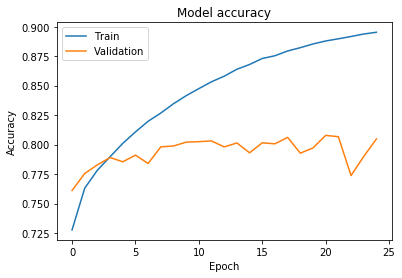

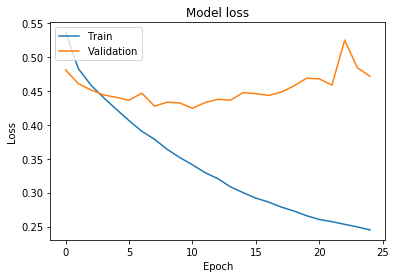

In [0]:

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [0]:
max_val_acc, idx = max((val, idx) for (idx, val) in enumerate(history.history['val_acc']))
print('Best accuracy at epoch', '{:d}'.format(idx+1), '=', '{:.4f}'.format(max_val_acc))
# best epoch is actually epoch 6... 0.8173.  See above.  (training done in 2 runs, loading the MODEL_WEIGHTS)

Best accuracy at epoch 21 = 0.8078


In [0]:
model.load_weights(PATH + MODEL_WEIGHTS)
loss, accuracy = model.evaluate([Q1_test, Q2_test], y_test, verbose=0)
print('Test set accuracy = {1:.4f}'.format(loss, accuracy))

Test set accuracy = 0.8125
